In [1]:
import os
import skeliner as sk
import trimesh
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt


In [2]:
MESH_PATH = Path("../data/720575940545220339.obj")
mesh = trimesh.load(MESH_PATH, process=False)

In [3]:
SOMA_SEED = np.array([59573, 67707, 892]) * np.array([16, 16, 40]) # from voxels to nm
SOMA_R = 7_500.0 # conservative lower-bound radius
LAMBDA = 1.15 # flood cut-off = SOMA_R0 × LAMBDA

if not os.path.exists("output/skeleton.swc"):
    skel = sk.skeletonize(mesh, seed=SOMA_SEED, seed_r=SOMA_R, lam=LAMBDA)
    skel.check_connectivity()
else:
    print("Skeleton already exists, skipping...")
    skel = sk.load_swc("output/skeleton.swc")

Text(0.5, 1.0, 'Zoomed in')

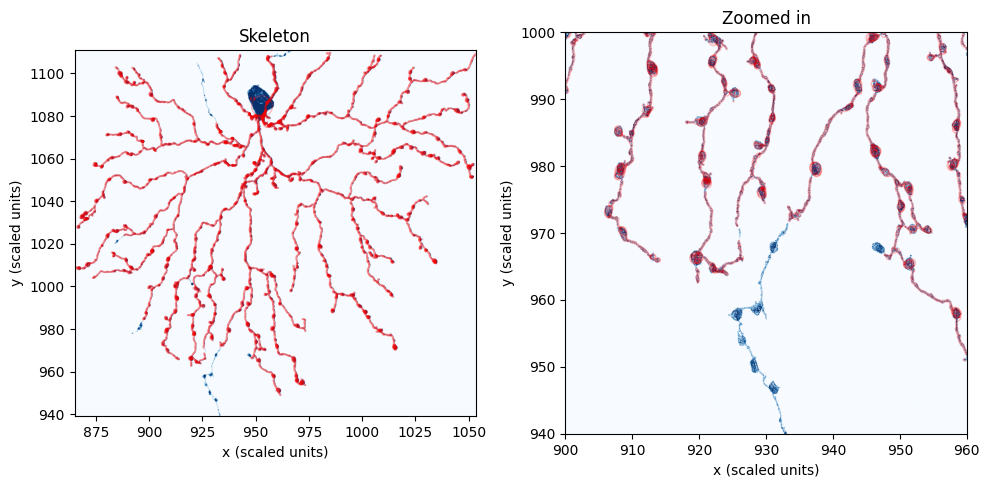

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sk.plot2d(
    skel, mesh,
    plane="xy",
    scale=1e-3, # nm → µm 
    # scale = [1, 1e-3]
    draw_edges=False,
    ax=ax[0]
)
sk.plot2d(
    skel, mesh,
    plane="xy",
    scale=1e-3,  
    # scale = [1, 1e-3]
    xlim=(900, 960),
    ylim=(940, 1000),
    draw_edges=False,
    ax=ax[1]
)
ax[0].set_title("Skeleton")
ax[1].set_title("Zoomed in")

There are broken paths because the mesh is not fully connected and there are gaps nevertheless.

In [5]:
if not os.path.exists("output"):
    os.makedirs("output")

if not os.path.exists("output/skeleton.swc"):
    skel.to_swc("output/skeleton.swc", scale=1e-3) # nm → µm
else:
    print("Skeleton already exists, skipping...")

To reconnect the broken paths, we need to treat each of the paths as an individual cell, and trace it the same way before: specifying a starting point, and run the same skeletonization process.

In [ ]:
path_seeds = [
    [58329, 60704, 969],
    [57952, 59549, 939],
    [56042, 61489, 942],
    [55778, 61136, 945],
    [55487, 63992, 974],
    [55391, 63901, 971],
    [58222, 67370, 1146],
    [59898, 69264, 1327],
    [57408, 62721, 1016],
    [59215, 60447, 965],
]

skels = []
for i, seed in enumerate(path_seeds):

    # check if the swc file already exists
    if os.path.exists(f"output/skeleton_broken_path_{i}.swc"):
        print(f"Skeleton for path {i} already exists, skipping...")
        continue

    print(f"Skeletonizing path {i}...")
    seed = np.array(seed) * np.array([16, 16, 40]) # from voxels to nm
    try:
        skel = sk.skeletonize(mesh, seed=seed, seed_r=200, lam=1, collapse_dist=0)
    except ValueError:
        print(f"Failed to skeletonize path {i}")
        continue

    skel.to_swc(f"output/skeleton_broken_path_{i}.swc", scale=1e-3)


Skeletonizing path 0...
Skeletonizing path 1...
Skeletonizing path 2...
Skeletonizing path 3...
Skeletonizing path 4...
Skeletonizing path 5...
Skeletonizing path 6...
Skeletonizing path 7...
Skeletonizing path 8...
Skeletonizing path 9...


With all the paths traced, we can merged it with the postprocessing utils.

In [ ]:
import glob

skels = []
for swc_path in glob.glob("output/*.swc"):
    skels.append(sk.load_swc(Path(swc_path))) 

skel_merged = sk.post.merge(skels)
skel_merged.to_swc("output/skeleton_broken_path_merged.swc", scale=1) # already in µm

Text(0.5, 1.0, 'Zoomed in')

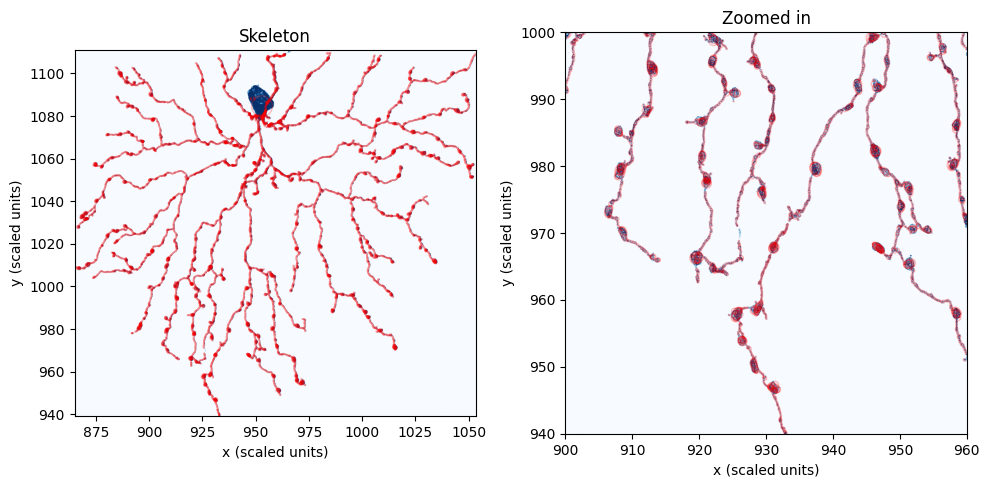

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sk.plot2d(
    skel_merged, mesh,
    plane="xy",
    scale=[1, 1e-3], # skel already in µm, mesh: nm → µm
    draw_edges=False,
    ax=ax[0]
)
sk.plot2d(
    skel_merged, mesh,
    plane="xy",
    scale=[1, 1e-3],  
    xlim=(900, 960),
    ylim=(940, 1000),
    draw_edges=False,
    ax=ax[1]
)
ax[0].set_title("Skeleton")
ax[1].set_title("Zoomed in")

In [9]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-05-15 18:16:59CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.2.0

matplotlib: 3.10.3
numpy     : 2.2.5
skeliner  : 0.1.0
trimesh   : 4.6.9

Watermark: 2.5.0

